<a href="https://colab.research.google.com/github/Kangsan419/Faster_RCNN-Report/blob/main/Object_Detection_Through_Faster_RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Object Detection With Faster-RCNN

Out team in Capstone Design decided to use Yolo algorithm over CNN derived algorithms due to the speed. Since we thought that real time detection and accuracy is essetial to our problem Yolo algorithms seemed to be better than CNN algorithms. 

However, as CNN deriven algorithms made a processes, they came up with faster processing speed with almost equal amount of accuracy. Thus I thought studying and making model out of latest CNN deriven algorithm, Faster-RCNN would help my team`s project when we have to compare and constrast each algorithms. 


In [2]:
%cd /content/drive/MyDrive/Object Detection Through Faster RCNN.ipynb


[Errno 20] Not a directory: '/content/drive/MyDrive/Object Detection Through Faster RCNN.ipynb'
/content


In [3]:
!git config --global user.email "rkdtks419@g.skku.edu"
!git config --global user.name "Kangsan419"

In [4]:
!git add .

fatal: not a git repository (or any of the parent directories): .git


In [ ]:
# Set up google drive in google colab

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Unzip training data from drive

%cd /content/drive/MyDrive/VOC

!unzip -q '/content/drive/MyDrive/VOC/VOCdevkit.zip'


/content/drive/MyDrive/VOC


In [ ]:
# If your file is ready move directory to VOCdevkit
%cd /content/drive/MyDrive/VOC/

/content/drive/MyDrive/VOC


# Import Libraries

In [ ]:
import random
import os
import math
import xml.etree.ElementTree as ET
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image,ImageFilter, ImageEnhance
import cv2
import torch.optim as optim
from torchvision.ops import nms
from tqdm import tqdm
import time

# Define Hyperparameter

In [ ]:

select_classes = {'aeroplane', 'bicycle','boat','bus', 'dog','train','motorbike'} # Only training for these classes



anchor_scale = torch.FloatTensor([8,16,32])  
anchor_ratio = torch.FloatTensor([0.5,1,2])  
conversion_scale = 16
input_image_height = 800
input_image_width = 800
num_anchors_sample = 256

# Non Maximum Suppression hyper parameters
nms_threshold = 0.7       # only consider anchors with IOU < nms_threshold
nms_num_train_pre = 12000 # Select top nms_num_train_pre anchors to apply nms on 
nms_num_train_post = 2000 # number of proposal regions after NMS
nms_num_test_pre = 6000   # For test 
nms_num_test_post = 300   # For test
nms_min_size = 16         # only consider anchors as valid while applying nms if ht and wt < nms_min_size


#proposal target (pt) hyper parameters
pt_n_sample = 128  #Number of samples to sample from roi
pt_pos_ratio = 0.25 #the number of positive examples out of the n_samples
pt_pos_iou_threshold  = 0.5 #Min overlap required between roi and gt for considering positive label (object)
pt_neg_iou_threshold = 0.5 # below this value marks as negative


#ROI pooling
roi_size = (7,7)

# RPN loss 
rpn_loss_lambda = 1 # same is used in the decider loss


# Number of validation images
num_valid_img = 150

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Handle Training Data

Get all classes and create label encoding

In [ ]:
# Getting all the classes and creating label encoding

all_labels = []


for out in sorted(os.listdir('VOCdevkit/VOC2007/Annotations/')):
    tree = ET.parse('VOCdevkit/VOC2007/Annotations/' + out)
    for obj in tree.findall('object'):
        lab = (obj.find('name').text)
        # all_labels.append(lab)
        if (lab in (select_classes)):
          all_labels.append(lab)
        
distict_labels = list(set(all_labels))
distict_labels = sorted(distict_labels)

#label 0 is set for background
lab_to_val = {j:i+1 for i,j in enumerate(distict_labels)}
val_to_lab = {i+1:j for i,j in enumerate(distict_labels)}

num_classes = len(distict_labels) + 1


print(np.unique(np.array(all_labels), return_counts=True)[0])
print(np.unique(np.array(all_labels), return_counts=True)[1])
print(num_classes)

['aeroplane' 'bicycle' 'boat' 'bus' 'dog' 'motorbike' 'train']
[331 418 398 272 538 390 328]
8


Data Augmentation

In [ ]:
# Random blur on training image
def random_blur(img):
  if random.random() < 0.5:
    return img
  
  rad = random.choice([1,2])
  img = img.filter(ImageFilter.BoxBlur(radius=rad))
  return img


# Random brightness, contrast, satutration and hue
def random_color(img):
  if random.random() < 0.1:
    return img

  img = transforms.ColorJitter(brightness=(0.5,2.0), contrast=(0.5,2.0), saturation=(0.5,2.0), hue=(-0.25,0.25))(img)
  return img

# Random horizontal flip
def random_flip(img, gt_box):
  if random.random() < 0.5:
    return img,gt_box

  img = transforms.RandomHorizontalFlip(p=1)(img)
  temp = (gt_box[:,1]).copy()
  gt_box[:,1] = img.size[0] - gt_box[:,0] #x1
  gt_box[:,0] = img.size[0] - temp #x2

  return img, gt_box


# Random crop on image
def random_crop(img, gt_box, labels):
  if random.random() < 0.5:
    return img,gt_box,labels
  width, height = img.size
  select_w = random.uniform(0.6*width, width)
  select_h = random.uniform(0.6*height, height)

  start_x = random.uniform(0,width - select_w)
  start_y = random.uniform(0,height - select_h)

  left = start_x
  upper = start_y
  right = start_x + select_w
  bottom = start_y + select_h

  gt_box_copy = gt_box.copy()

  gt_box_copy[gt_box_copy[:,0] < left, 0] = left
  gt_box_copy[gt_box_copy[:,1] > right, 1] = right
  gt_box_copy[gt_box_copy[:,2] < upper, 2] = upper
  gt_box_copy[gt_box_copy[:,3] > bottom, 3] = bottom

  final_gt_box = []
  final_labels = []

  for i in range((gt_box_copy.shape[0])):
    if (((gt_box_copy[i,1] - gt_box_copy[i,0])/(gt_box[i,1]-gt_box[i,0])) < 0.5):
      continue
    if (((gt_box_copy[i,3] - gt_box_copy[i,2])/(gt_box[i,3] - gt_box[i,2])) < 0.5):
      continue
    final_gt_box.append(gt_box_copy[i])
    final_labels.append(labels[i])

  if len(final_gt_box) == 0:
    return img,gt_box,labels

  final_gt_box = np.array(final_gt_box)
  final_gt_box[:,0] = final_gt_box[:,0] - left
  final_gt_box[:,1] = final_gt_box[:,1] - left
  final_gt_box[:,2] = final_gt_box[:,2] - upper
  final_gt_box[:,3] = final_gt_box[:,3] - upper

  return img.crop((left, upper, right, bottom)), final_gt_box, final_labels

Create Pytorch Dataset and Dataloader

In [ ]:
class pascal_voc_data(Dataset):
    def __init__(self, img_dir,desc_dir,type_list, isTrain, transform = None):
        super().__init__()
        self.img_dir = img_dir
        self.desc_dir = desc_dir
        self.type_list = type_list
        self.isTrain = isTrain
        self.transform = transform


        self.img_names = []
        self.img_descs = []
        for img in sorted(os.listdir(img_dir)):
          if img[:-4] in self.type_list:
            self.img_names.append(img)
        
        for desc in sorted(os.listdir(desc_dir)):
          if desc[:-4] in  self.type_list:
            self.img_descs.append(desc)
       
        self.img_names = [os.path.join(img_dir, img_name) for img_name in self.img_names]
        self.img_descs = [os.path.join(desc_dir, img_desc) for img_desc in self.img_descs]

        
        # self.img_names = sorted(os.listdir(img_dir))
        # self.img_descs = sorted(os.listdir(desc_dir))
        
        # self.img_names = [os.path.join(img_dir, img_name) for img_name in self.img_names]
        # self.img_descs = [os.path.join(desc_dir, img_desc) for img_desc in self.img_descs]
                
        
        self.loc_gts = []
        self.loc_labels = []
        self.final_img_names = []
        for img_idx,img_desc in enumerate(self.img_descs):
            tree = ET.parse(img_desc)
            gt = []
            loc_lab = []
            for obj in tree.findall('object'):
              if ((obj.find('name').text) not in (select_classes)):
                continue
              lab = lab_to_val[(obj.find('name').text)]
              
              loc1 = int(obj.find('bndbox').find('xmin').text)
              loc2 = int(obj.find('bndbox').find('xmax').text)
              loc3 = int(obj.find('bndbox').find('ymin').text)
              loc4 = int(obj.find('bndbox').find('ymax').text)

              # if ht or width is less than 10, ignore the gt box
              if ((loc2 - loc1) < 10 ) or ((loc4 - loc3) < 10):
                continue

              gt.append([int(loc1),int(loc2),int(loc3),int(loc4)])
              loc_lab.append(lab)
            if (len(gt) == 0):
              continue
            self.loc_gts.append(gt)
            self.loc_labels.append(loc_lab)
            self.final_img_names.append(self.img_names[img_idx])

        self.img_names = self.final_img_names
             
    def __len__(self):
        return len(self.img_names)
    
    def __getitem__(self,idx):
        img_name = self.img_names[idx]
        img = Image.open(img_name)

        arr_loc_gts = np.array(self.loc_gts[idx])
        label = self.loc_labels[idx]

        if self.isTrain:
          img = random_blur(img)
          img = random_color(img)
          img,arr_loc_gts = random_flip(img,arr_loc_gts)
          img,arr_loc_gts,label = random_crop(img,arr_loc_gts,label)
        
        img_h_pre = img.size[1]
        img_w_pre = img.size[0]
        
        if self.transform:
            img = self.transform(img)
            
        img_h_post = img.shape[1]
        img_w_post = img.shape[2]
        
        height_ratio = img_h_post/img_h_pre
        width_ratio = img_w_post/img_w_pre
      
        
        
        arr_loc_gts[:,0] = arr_loc_gts[:,0]*width_ratio
        arr_loc_gts[:,1] = arr_loc_gts[:,1]*width_ratio
        arr_loc_gts[:,2] = arr_loc_gts[:,2]*height_ratio
        arr_loc_gts[:,3] = arr_loc_gts[:,3]*height_ratio
                        
        gts = (arr_loc_gts).tolist()
        
        
        return img, gts,label

In [ ]:
'''
While using pretrained models - 
Pytorch torchvision documentation - https://pytorch.org/docs/master/torchvision/models.html
The images have to be loaded in to a range of [0, 1] and then 
normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]
'''

transform = transforms.Compose(
    [transforms.Resize((input_image_height,input_image_width)),
     transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])


inv_normalize = transforms.Normalize(
   mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
   std=[1/0.229, 1/0.224, 1/0.225]
)

Split into train and validations

In [ ]:
file = open('/content/drive/MyDrive/VOC/VOCdevkit/VOC2007/ImageSets/Segmentation/val.txt', "r")
valid_images = file.read().split('\n')
valid_images = valid_images[:-1]


train_images = []
for img in os.listdir('VOCdevkit/VOC2007/JPEGImages/'):
  if img[:-4] in valid_images:
    continue
  train_images.append(img[:-4])

In [ ]:
train_dataset = pascal_voc_data('VOCdevkit/VOC2007/JPEGImages/', 'VOCdevkit/VOC2007/Annotations/',train_images , True,transform)
valid_dataset = pascal_voc_data('VOCdevkit/VOC2007/JPEGImages/', 'VOCdevkit/VOC2007/Annotations/',valid_images ,False,transform)

In [ ]:
print(len(train_dataset))
print(len(valid_dataset))

1690
87



Validation class images

In [ ]:
test_loader = DataLoader(valid_dataset, batch_size = len(valid_dataset))
a,b,c = iter(test_loader).next()
print(torch.unique(c[0], return_counts=True))

NameError: ignored

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=1)
valid_loader = DataLoader(valid_dataset, batch_size=1,shuffle=True)


##Visualise input image with box co-ordinates provided in format - x0,x1,y0,y1

In [ ]:
# Given input image, draw rectangles as specified by gt_box and pred_box and display
def visualize_tensor(img, gt_box, pred_box,save_image='',tb_writer=None):
    plt.figure(figsize=(5,5))
    transform_img = inv_normalize(img[0]).permute(1,2,0).to('cpu').numpy()
    transform_img = transform_img.copy()
    for box in gt_box:
        x0, x1, y0, y1 = box
        cv2.rectangle(transform_img, (int(x0),int(y0)), (int(x1),int(y1)), color=(0, 255, 255), thickness=2)
    for box in pred_box:
        x0, x1, y0, y1 = box
        cv2.rectangle(transform_img, (int(x0), int(y0)), (int(x1), int(y1)), color=(255, 0, 0), thickness=2)
    
    if tb_writer:
      # grid = torchvision.utils.make_grid(transform_img)
      tb_writer.add_image(save_image, transform_img, dataformats='HWC')
    elif save_image == '':
        plt.imshow(transform_img)
        plt.show()  
    else:
        plt.imshow(transform_img)
        plt.savefig(save_image + '.png')

##Faster RCNN backbone used - VGG16 model


  Top 10 layers (top 4 conv layers) are not trained

In [ ]:
# Base VGG16 model

def Faster_RCNN_vgg16(num_freeze_top): 
    vgg16 = models.vgg16(pretrained=True)
    vgg_feature_extracter  = vgg16.features[:-1]
    vgg_classifier = vgg16.classifier[:-1]
    
    # Freeze learning of top few conv layers
    for layer in vgg_feature_extracter[:num_freeze_top]:
        for param in layer.parameters():
            param.requires_grad = False
    
    return vgg_feature_extracter.to(device), vgg_classifier.to(device)

##Code for anchor generation on an image


For train and test, only anchors lying inside the image boundary are considered

In [ ]:
'''
    RCNN Paper
    For anchors, we use 3 scales with box areas of (128*128) || (256*256) , and (512*512) pixels, 
    and 3 aspect ratios of 1:1, 1:2, and 2:1.

'''

# At point x,y from feature map, return 9 anchors on the input image scale
def generate_anchor_at_point(x,y):
    anchor_positions = torch.zeros((len(anchor_scale) * len(anchor_ratio),4))
    ctr_x = (x*2+1)*(conversion_scale/2)   # for x = 0, centre is 8 || for x = 1, centre is 24
    ctr_y = (y*2+1)*(conversion_scale/2)
    for ratio_idx in range(len(anchor_ratio)):
        for scale_idx in range(len(anchor_scale)):

            current = len(anchor_scale)*ratio_idx + scale_idx
            ratio = anchor_ratio[ratio_idx]
            scale = anchor_scale[scale_idx]

            h = conversion_scale*scale*torch.sqrt(ratio)
            w = conversion_scale*scale*torch.sqrt(1.0/ratio)
            
            anchor_positions[current,0] = ctr_x - w/2
            anchor_positions[current,1] = ctr_x + w/2
            anchor_positions[current,2] = ctr_y - h/2
            anchor_positions[current,3] = ctr_y + h/2
            
    return anchor_positions


# For features of scale (x,y) , generate all the anchor boxes
# input is height,width
# returns output on  x*y*9,4
def generate_anchors(x,y):
    anchor_positions = torch.zeros((x*y,len(anchor_scale) * len(anchor_ratio),4))
    for ctr_x in range(x):
        for ctr_y in range(y):
            current = ctr_x*y + ctr_y
            anchors = generate_anchor_at_point(ctr_x, ctr_y)
            anchor_positions[current] = anchors
    return anchor_positions.reshape(-1,4)

In [ ]:
'''
RCNN paper
    - During training, we ignore all cross-boundary anchors so they do not contribute to the loss
    - During testing, however, we still apply the fully convolutional RPN to the entire image. This may 
    generate crossboundary proposal boxes, which we clip to the image boundary
'''

'''
    For this code, cross boundary anchors are ignored at this step both in train and test
'''

def get_valid_anchors(anchor_positions):
    valid_anchors_idx = torch.where((anchor_positions[:,0] >= 0) & 
             (anchor_positions[:,1] <= input_image_width) &
             (anchor_positions[:,2] >= 0) &
             (anchor_positions[:,3] <= input_image_height) )[0]

    anchor_positions = anchor_positions[valid_anchors_idx]
    return anchor_positions, valid_anchors_idx
    
# valid_anchors,valid_anchors_idx = get_valid_anchors(anchor_positions)
# print(valid_anchors)

##Getting intersection over union between 2 sets of boxes

In [ ]:
# Get Intersection over Union between all the boxes in anchor_positions and gt_boxes

def get_iou_matrix(anchor_positions, gt_boxes):
    iou_matrix = torch.zeros((len(anchor_positions), len(gt_boxes)))
    for idx,box in enumerate(gt_boxes):
        if isinstance(box,torch.Tensor):
          gt = torch.cat([box]*len(anchor_positions)).view(1,-1,4)[0]
        else:
          gt = torch.FloatTensor([box]*len(anchor_positions))
        max_x = torch.max(gt[:,0],anchor_positions[:,0])
        min_x = torch.min(gt[:,1],anchor_positions[:,1])
        max_y = torch.max(gt[:,2],anchor_positions[:,2])
        min_y = torch.min(gt[:,3],anchor_positions[:,3])
                
        invalid_roi_idx = (min_x < max_x) | (min_y < max_y)
        roi_area = (min_x - max_x)*(min_y - max_y)
        roi_area[invalid_roi_idx] = 0
        
        total_area = (gt[:,1] - gt[:,0])*(gt[:,3] - gt[:,2]) + \
                    (anchor_positions[:,1] - anchor_positions[:,0])*(anchor_positions[:,3]-anchor_positions[:,2]) - \
                     roi_area
                    
        iou = roi_area/(total_area + 1e-6)
        
        iou_matrix[:,idx] = iou
    return iou_matrix
        

##After IOU calculation between anchors and gt boxes






*   Assign +1/-1/0 labels to anchors based on IOU
*   Sample 128 positive and 128 negative anchors for training
*  If less than 128 positive anchors, pad with negative





  

In [ ]:
'''
    RCNN paper: 
        assign a positive label to two kinds of anchors: 
        (i) the anchor/anchors with the highest Intersection-overUnion (IoU) overlap with a ground-truth box, 
        (ii) an anchor that has an IoU overlap higher than 0.7 with
    
        assign a negative label to a non-positive anchor if its IoU ratio is lower than 0.3 
        Anchors that are neither positive nor negative do not contribute to the training objective.
        
'''

def get_max_iou_data(iou_matrix):
    gt_max_value = iou_matrix.max(axis=0)[0] #  for each gt box, this is the max iou
    
    #There is a possiblilty that corresponding to one gt box, there are multiple anchors with same iou (max value)
    all_gt_max = torch.where(iou_matrix == gt_max_value)[0]
    
    # For each anchor box, this is the max iou with any of the gt_box
    anchor_max_value = torch.max(iou_matrix, axis=1)[0]
    anchor_max = torch.argmax(iou_matrix, axis=1)
    
    return all_gt_max, anchor_max_value,anchor_max



# 1 - positive || 0 - negative || -1 - ignore
def get_anchor_labels(anchor_positions, all_gt_max, anchor_max_value):
    anchor_labels = torch.zeros(anchor_positions.shape[0])
    anchor_labels.fill_(-1.0)

    # for each anchor box, if iou with any of the gt_box is less than threshold, mark as 0
    anchor_labels[anchor_max_value < 0.3] = 0
    
    # If corresponding to any gt_box, the anchor has max iou -> mark as 1
    anchor_labels[all_gt_max] = 1.0
    
    # If for any anchor box, iou is greater than threshold for any of the gt_box, mark as 1
    anchor_labels[anchor_max_value > 0.7] = 1.0
    return anchor_labels

In [ ]:
'''
 RCNN paper 
    randomly sample 256 anchors in an image to compute the loss function of a mini-batch, where
    the sampled positive and negative anchors have a ratio of up to 1:1. If there are fewer 
    than 128 positive samples in an image, we pad the mini-batch with negative ones.
'''

def sample_anchors_for_train(anchor_labels):
    pos_anchor_labels = torch.where(anchor_labels == 1)[0]
    num_pos = min(num_anchors_sample/2, len(pos_anchor_labels))
    pos_idx = np.random.choice(pos_anchor_labels,  int(num_pos), replace=False)

    neg_anchor_labels = torch.where(anchor_labels == 0)[0]
    num_neg = num_anchors_sample - num_pos
    neg_idx = np.random.choice(neg_anchor_labels, int(num_neg), replace=False)
    
    anchor_labels[:] = -1
    anchor_labels[pos_idx] = 1
    anchor_labels[neg_idx] = 0
    
    return anchor_labels


##bbox regression training data calculation


*  delta_anchor_gt - Get delta between anchor_positions and gt_boxes
*   correct_anchor_positions - Given delta and anchor_positions, correct the anchors

In [ ]:
'''
    x,y,w,h are ctr_x, ctr_y, width and height for GT box
    dx = (x - x_{a})/w_{a}
    dy = (y - y_{a})/h_{a}
    dw = log(w/ w_a)
    dh = log(h/ h_a)
'''

# Get delta between anchor_positions and gt_boxes
def delta_anchor_gt(anchor_positions, gt_boxes , anchor_max):

    anchor_gt_map =  gt_boxes[anchor_max]
    
    anchor_height = anchor_positions[:,3] - anchor_positions[:,2] # y2-y1
    anchor_width =  anchor_positions[:,1] - anchor_positions[:,0] # x2-x1
    anchor_ctr_y = anchor_positions[:,2] + anchor_height/2 # y1 + h/2
    anchor_ctr_x = anchor_positions[:,0] + anchor_width/2  # x1 + w/2
    
    gt_height = anchor_gt_map[:,3] - anchor_gt_map[:,2] # y2-y1
    gt_width =  anchor_gt_map[:,1] - anchor_gt_map[:,0] # x2-x1
    gt_ctr_y = anchor_gt_map[:,2] + gt_height/2 # y1 + h/2
    gt_ctr_x = anchor_gt_map[:,0] + gt_width/2  # x1 + w/2
    
    dx = (gt_ctr_x - anchor_ctr_x)/anchor_width
    dy = (gt_ctr_y - anchor_ctr_y)/anchor_height
    dw = torch.log(gt_width/anchor_width)
    dh = torch.log(gt_height/anchor_height)
    
    delta = torch.zeros_like(anchor_positions)
    delta[:,0] = dx
    delta[:,1] = dy
    delta[:,2] = dw
    delta[:,3] = dh
   
    return delta


# Given delta and anchor_positions, correct the anchors
def correct_anchor_positions(anchor_positions, delta):
    ha = anchor_positions[:,3] - anchor_positions[:,2] # y2-y1
    wa =  anchor_positions[:,1] - anchor_positions[:,0] # x2-x1
    ya = anchor_positions[:,2] + ha/2 # y1 + h/2
    xa = anchor_positions[:,0] + wa/2  # x1 + w/2
    
    dx = delta[:,0]
    dy = delta[:,1]
    dw = delta[:,2]
    dh = delta[:,3]
    
    
    x = dx*wa + xa
    y = dy*ha + ya
    w = torch.exp(dw)*wa
    h = torch.exp(dh)*ha
    
    correct_anchor_positions = torch.zeros_like(anchor_positions)
    
    correct_anchor_positions[:,0] = x - w/2
    correct_anchor_positions[:,1] = x + w/2
    correct_anchor_positions[:,2] = y - h/2
    correct_anchor_positions[:,3] = y + h/2
    
    return correct_anchor_positions

##Faster RCNN region proposal network defination


In [ ]:
# Region Proposal Network

class Faster_RCNN_rpn(nn.Module):
    def __init__(self,extracter):
        super().__init__()
        self.extracter = extracter
        self.conv1 = nn.Conv2d(512, 512, 3, 1, 1)
        #class_conv1 checks corresponding to 1 point in feature map, 18 outputs. 
        # 9 anchors * (2) || anchor has object or not
        self.class_conv = nn.Conv2d(512, 2*len(anchor_scale)*len(anchor_ratio), 1, 1, 0)  
        #reg_conv1 checks corresponding to 1 point in feature map, 36 outputs. 
        # 9 anchors * (4) || anchor delta wrt ground truth boxes
        self.reg_conv = nn.Conv2d(512, 4*len(anchor_scale)*len(anchor_ratio), 1 ,1 , 0)

        self.conv1.weight.data.normal_(0, 0.01)
        self.conv1.bias.data.zero_()
        self.class_conv.weight.data.normal_(0, 0.01)
        self.class_conv.bias.data.zero_()
        self.reg_conv.weight.data.normal_(0, 0.01)
        self.reg_conv.bias.data.zero_()

        
        
    def forward(self,x):
        # input and output features of CNN are (nSamples x nChannels x Height x Width)
        
        features = self.extracter(x)
        conv1_out = F.relu(self.conv1(features))
        class_out = self.class_conv(conv1_out)
        reg_out = self.reg_conv(conv1_out)
        
        return features, class_out, reg_out

##Loss calculation - The same loss function is used for decider and RPN layer

In [ ]:
# Loss for Region Proposal Netwoek
# Same loss is used for decider network

def RPN_loss(locs_preditct, class_predict, final_RPN_locs,final_RPN_class):
    final_RPN_locs = final_RPN_locs.to(device)
    final_RPN_class = final_RPN_class.long().to(device)
    
    # Cross entropy loss (check if the target is background or foreground)
    # Only consider labels with values 1 or 0. ignore -1
    class_loss = F.cross_entropy(class_predict, final_RPN_class, ignore_index=-1)

    #smooth L1 regression loss (calculate the loss in predicted locations of foreground)
    '''
        Smooth L1 loss uses a squared term if the absolute element-wise error falls below 1 and an L1 term otherwise
    '''

    foreground_class_idx = (final_RPN_class > 0)
    locs_preditct  = locs_preditct[foreground_class_idx]
    final_RPN_locs = final_RPN_locs[foreground_class_idx]

 
    
    loc_loss = F.smooth_l1_loss(locs_preditct, final_RPN_locs) / (sum(foreground_class_idx)+1e-6)

    
    rpn_loss = class_loss + rpn_loss_lambda*loc_loss
  
    return rpn_loss

##Non Maximum Suppression
 
*   Custom implemented method is implemented but not used
*   Pytorch nms method gives ~5-6 times speed up


 

In [ ]:
# Apply non max suppression on anchors

def non_max_suppression(correct_anchor_positions, class_score, img_h, img_w, isTrain):
    
    if isTrain:
        nms_pre = nms_num_train_pre
        nms_post = nms_num_train_post
    else :
        nms_pre = nms_num_test_pre
        nms_post = nms_num_test_post
    
    
    # Clip the anchors to image dimensions
    correct_anchor_positions[correct_anchor_positions[:,0] < 0,0] = 0 # x1
    correct_anchor_positions[correct_anchor_positions[:,1] > img_w,1] = img_w # x2
    correct_anchor_positions[correct_anchor_positions[:,2] < 0,2] = 0 # y1
    correct_anchor_positions[correct_anchor_positions[:,3] > img_h,3] = img_h # y2
    
    
    # Only keep anchors with height and width > nms_min_size
    anchor_width = correct_anchor_positions[:,1] - correct_anchor_positions[:,0]
    anchor_height = correct_anchor_positions[:,3] - correct_anchor_positions[:,2]


    
    keep_idx = (anchor_height > nms_min_size) & (anchor_width > nms_min_size)
    correct_anchor_positions = correct_anchor_positions[keep_idx]
    class_score = class_score[keep_idx]

    # Get the index of sorted class scores in descending order and select top nms_pre idx
    sorted_class_scores = torch.argsort(class_score, descending=True)
    pre_nms_idx = sorted_class_scores[:nms_pre]
    correct_anchor_positions = correct_anchor_positions[pre_nms_idx]
    class_score = class_score[pre_nms_idx]
    
    # Implementation for non max suppression
    '''
    sorted_class_scores = torch.argsort(class_score, descending=True).to('cpu')
    keep_anchors = []
    

    Apply NMS
    while len(sorted_class_scores) > 1:
        current = sorted_class_scores[0]
        keep_anchors.append(current)
        iou_matrix = get_iou_matrix(correct_anchor_positions[sorted_class_scores[1:]],correct_anchor_positions[current].reshape(1,-1,4)[0])
        sorted_class_scores = sorted_class_scores[np.where(iou_matrix < nms_threshold)[0] + 1]
    
    if (len(sorted_class_scores) == 1):
        keep_anchors.append(sorted_class_scores[0])
    '''


    '''
      using pytorch standard nms function as it gives 5-6 times speedup
    '''
    change_format = torch.zeros_like(correct_anchor_positions)
    change_format[:,0] = correct_anchor_positions[:,0]
    change_format[:,1] = correct_anchor_positions[:,2]
    change_format[:,2] = correct_anchor_positions[:,1]
    change_format[:,3] = correct_anchor_positions[:,3]

    keep_anchors = nms(change_format.to('cpu'), class_score.clone().detach().to('cpu'), nms_threshold)

    keep_anchors = keep_anchors[:nms_post]
    correct_anchor_positions = correct_anchor_positions[keep_anchors]
    
    return correct_anchor_positions


##Assign classes to output of Region Proposal Network

In [ ]:
def assign_classification_anchors(extracted_roi, gt_boxes, gt_labels, isTrain):

    
    # calculate iou of rois and gt boxes
    iou_matrix = get_iou_matrix(extracted_roi, gt_boxes)
    
    # for each ROI, find gt with max iou and corresponding value
    gt_roi_argmax = iou_matrix.argmax(axis=1)
    gt_roi_max = iou_matrix.max(axis=1)[0]
    
    #If a particular ROI has max overlap with a gt_box, assign label of gt_box to roi
    assign_labels = gt_labels[gt_roi_argmax]
    
    num_pos = pt_n_sample*pt_pos_ratio
    pos_idx = torch.where(gt_roi_max > pt_pos_iou_threshold)[0]
    if isTrain:
      pos_idx = np.random.choice(pos_idx, int(min(len(pos_idx), num_pos)), replace=False)
    
    
    num_neg = pt_n_sample - len(pos_idx)
    neg_idx = torch.where(gt_roi_max < pt_neg_iou_threshold)[0]
    if isTrain:
      neg_idx = np.random.choice(neg_idx, int(min(len(neg_idx), num_neg)), replace=False)
    
    
    keep_idx = np.append(pos_idx, neg_idx)
    assign_labels[neg_idx] = 0
    assign_labels = assign_labels[keep_idx]
    extracted_roi = extracted_roi[keep_idx]
    gt_roi_argmax = gt_roi_argmax[keep_idx]

    
    return assign_labels, extracted_roi,gt_roi_argmax, keep_idx

##ROI Pooling Layer

In [ ]:
def ROI_pooling(extracted_roi, feature,ROI_pooling_layer):
    extracted_roi = extracted_roi/16.0
    out = []
    for roi in extracted_roi:
        
        x1 = int(roi[0])
        x2 = int(roi[1]+1)
        y1 = int(roi[2])
        y2 = int(roi[3]+1)
        out.append(ROI_pooling_layer(feature[:,:,y1:y2,x1:x2]))
    out = torch.cat(out)
    return out

##Faster RCNN decider layer definition


In [ ]:
class Faster_RCNN_decider(nn.Module):
    def __init__(self,classifier):
        super().__init__()
        self.flatten = nn.Flatten()
        self.classifier = classifier
        self.class_lin = nn.Linear(4096, num_classes)
        self.reg_lin = nn.Linear(4096, num_classes*4)

        
    def forward(self, x):
        x = self.flatten(x)
        x = self.classifier(x)
        decider_class = self.class_lin(x)
        decider_loc = self.reg_lin(x)
        
        return decider_class, decider_loc

##Pipeline (train/validation) for a single image

In [ ]:
img_anchors_all = generate_anchors(int(input_image_height/conversion_scale), int(input_image_width/conversion_scale)).to(device)

def single_image_pipeline(input_image, gt_box, label,isTrain):

    input_image = input_image.to(device)
    gt_box = torch.FloatTensor(gt_box).to(device)
    label = torch.FloatTensor(label).to(device)

    # Generate CNN features for input image
    # Genearate region proposals predictions
    features, class_out, reg_out = rpn(input_image)


    locs_preditct = reg_out.permute(0,2,3,1).reshape(1,-1,4)[0]
    class_predict = class_out.permute(0,2,3,1).reshape(1,-1,2)[0]
    class_score = class_out.reshape(1,features.shape[2],features.shape[3],9,2)[:,:,:,:,1].reshape(1,-1)[0].detach()

    
   
    # For training region proposal network, generate anchors on the image. 
    img_anchors_valid, img_anchors_valid_idx = get_valid_anchors(img_anchors_all.clone())

    iou_anchors_gt = get_iou_matrix(img_anchors_valid, gt_box)
    all_gt_max, anchor_max_value,anchor_max = get_max_iou_data(iou_anchors_gt)
    

    anchor_labels = get_anchor_labels(img_anchors_valid, all_gt_max, anchor_max_value)
    anchor_labels = sample_anchors_for_train(anchor_labels)
    
    # TODO - check if correct. - Done
    delta = delta_anchor_gt(img_anchors_valid, gt_box, anchor_max)
    

    

    final_RPN_locs = torch.zeros_like(img_anchors_all)
    final_RPN_locs[img_anchors_valid_idx] = delta

    final_RPN_class = torch.zeros(img_anchors_all.shape[0])
    final_RPN_class.fill_(-1)
    final_RPN_class[img_anchors_valid_idx] = anchor_labels

    # Loss for RPN layer
    loss1 = RPN_loss(locs_preditct, class_predict, final_RPN_locs, final_RPN_class).to(device)
    
    # Based on the bbox output of rpn, correct the generated anchors
    corrected_anchors = correct_anchor_positions(img_anchors_all.to(device), locs_preditct).detach()

    
    
    # Apply nms on the region proposals
    extracted_rois = non_max_suppression(corrected_anchors, class_score, input_image.shape[2],input_image.shape[3],isTrain)

   
    final_decider_class, extracted_roi_samples,gt_roi_argmax,idx = assign_classification_anchors(extracted_rois, gt_box, label, isTrain)

    final_decider_locs = delta_anchor_gt(extracted_roi_samples, gt_box,gt_roi_argmax)
   
    # Apply ROI pooling on the extracted ROIs
    pooled_features = ROI_pooling(extracted_roi_samples, features, ROI_pooling_layer)

    decider_class, decider_loc = decider(pooled_features)
    decider_loc = decider_loc.reshape(pooled_features.shape[0],-1,4) # 128*21*4
    decider_loc = decider_loc[torch.arange(0,pooled_features.shape[0]), final_decider_class.long()] # 128*4
    
    # Loss for decider layer
    loss2 = RPN_loss(decider_loc, decider_class, final_decider_locs, final_decider_class).to(device)
    
    with torch.no_grad():
        decider_loc_no_grad = decider_loc.clone().to(device)

    # Correct the ROIs based on bbox output for decider layers
    corrected_roi = correct_anchor_positions(extracted_roi_samples,decider_loc_no_grad).detach()
    
    return loss1, loss2 , decider_class, corrected_roi

##Test model for input image

In [ ]:
def test_model(input_image):
  rpn.eval()
  decider.eval()

  input_image = input_image.to(device)
  features, class_out, reg_out = rpn(input_image)
  locs_preditct = reg_out.permute(0,2,3,1).reshape(1,-1,4)[0]
  class_score = class_out.reshape(1,features.shape[2],features.shape[3],9,2)[:,:,:,:,1].reshape(1,-1)[0].detach()

  corrected_anchors = correct_anchor_positions(img_anchors_all.to(device), locs_preditct).detach()

    
  extracted_rois = non_max_suppression(corrected_anchors, class_score, input_image.shape[2],input_image.shape[3],False)


  pooled_features = ROI_pooling(extracted_rois, features, ROI_pooling_layer)

  decider_class, decider_loc = decider(pooled_features)
  
  with torch.no_grad():
        decider_loc_no_grad = decider_loc.clone().to(device)

  corrected_roi = correct_anchor_positions(extracted_rois,decider_loc_no_grad).detach()
  corrected_roi[corrected_roi[:,0] < 0,0] = 0 # x1
  corrected_roi[corrected_roi[:,1] > input_image_width,1] = input_image_width # x2
  corrected_roi[corrected_roi[:,2] < 0,2] = 0 # y1
  corrected_roi[corrected_roi[:,3] > input_image_height,3] = input_image_height # y2

  print(corrected_roi)

  decoder_conf = decider_class.softmax(dim=1).max(dim=1)[0]
  decoder_conf = decoder_conf.detach()
  decoder_conf = decoder_conf[decider_class.argmax(axis=1) != 0]
  

  keep_anchors = []
  sorted_class_scores = torch.argsort(decoder_conf, descending=True)

  while len(sorted_class_scores) > 1:
    current = sorted_class_scores[0]
    keep_anchors.append(current.item())
    iou_matrix = get_iou_matrix(corrected_roi[sorted_class_scores[1:]],corrected_roi[current].reshape(1,-1,4)[0])
    sorted_class_scores = sorted_class_scores[np.where(iou_matrix < 0.2)[0] + 1]

  if (len(sorted_class_scores) == 1):
    keep_anchors.append(sorted_class_scores[0].item())

  for pred in decider_class.argmax(axis=1)[decider_class.argmax(axis=1) != 0][keep_anchors]:
        print(val_to_lab[int(pred)], end=', ')
  print('')
  
  for pred in decoder_conf[keep_anchors]:
        print(pred.item(), end=', ')

  visualize_tensor(input_image,extracted_rois[decider_class.argmax(axis=1) != 0][keep_anchors], [])

##Use a single image pipeline multiple times for training or batch testing


Define variables, models, load saved models or training steps

In [ ]:
load_model = ''



loss1_hist = []
loss2_hist = []
loss_hist = []
valid_loss1_hist = []
valid_loss2_hist = []
valid_loss_hist = []
epoch_start = 0
best_valid_score = 10000


vgg_feature_extracter, vgg_classifier = Faster_RCNN_vgg16(num_freeze_top=10)
rpn = Faster_RCNN_rpn(vgg_feature_extracter).to(device)
ROI_pooling_layer = nn.AdaptiveMaxPool2d(roi_size).to(device)
decider = Faster_RCNN_decider(vgg_classifier).to(device)
all_params = list(list(rpn.parameters()) + list(decider.parameters()))


optimizer = optim.Adam(all_params, lr=0.00005)





if load_model != '':
  print('loading model ... ')
  checkpoint = torch.load(load_model, map_location=device)
  rpn.load_state_dict(checkpoint['rpn_state_dict'])
  decider.load_state_dict(checkpoint['decider_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  loss1_hist = checkpoint['loss1_hist']
  loss2_hist = checkpoint['loss2_hist']
  loss_hist = checkpoint['loss_hist']
  valid_loss1_hist =checkpoint['valid_loss1_hist']
  valid_loss2_hist = checkpoint['valid_loss2_hist']
  valid_loss_hist = checkpoint['valid_loss_hist']
  epoch_start = checkpoint['epoch_start']
  best_valid_score = checkpoint['best_valid_score']
  rpn.train()
  decider.train()

  print('model loaded ...' )


running_count = 0
running_net_loss = 0
running_loss1 = 0
running_loss2 = 0
loss_avg_step = 20
train_visualise_step  =150

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Faster RCNN train/validation code (Supported batch size is 1)

Start epoch - 0
best_valid_score - 10000
0--19--- tensor(1.4571, device='cuda:0')
0--39--- tensor(0.9050, device='cuda:0')
0--59--- tensor(0.6673, device='cuda:0')
0--79--- tensor(0.6752, device='cuda:0')
0--99--- tensor(0.7789, device='cuda:0')
0--119--- tensor(0.6435, device='cuda:0')
0--139--- tensor(0.5120, device='cuda:0')
Train Data Visualise


TypeError: ignored

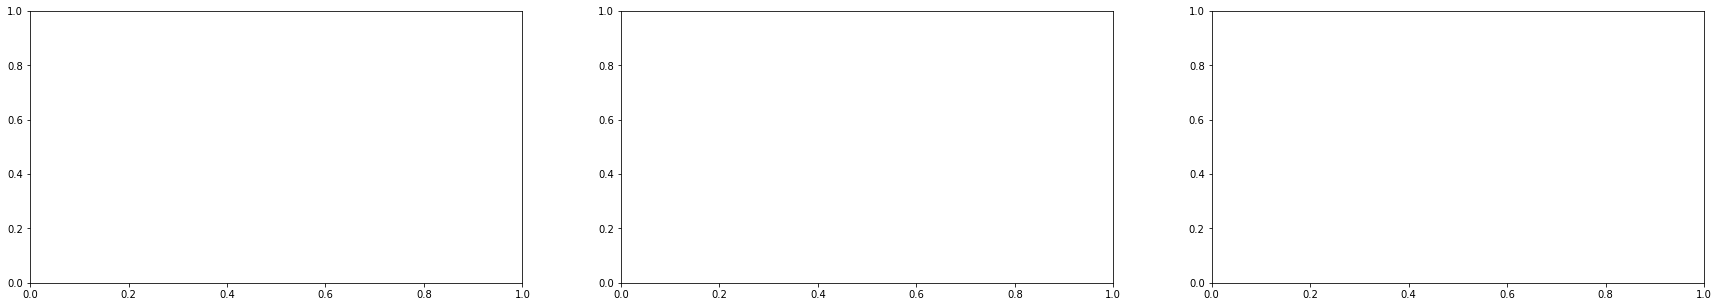

In [ ]:
print("Start epoch - " + str(epoch_start))
print("best_valid_score - " + str(best_valid_score))
for epoch in range(epoch_start,epoch_start+50):
    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
    for i, data in enumerate(train_loader, 0):

        img, gt_box, labels = data

        loss1, loss2, pred_class, pred_box = single_image_pipeline(img.to(device), gt_box, labels, True)
        net_loss = loss1 + loss2

        optimizer.zero_grad()
        net_loss.backward()
        optimizer.step()

        loss1 = loss1.detach()
        loss2 = loss2.detach()
        pred_class = pred_class.detach()
        pred_box = pred_box.detach()
        net_loss = net_loss.detach()
        if not((math.isnan(net_loss)) or (math.isnan(loss1)) or (math.isnan(loss2))):
            running_count += 1
            running_net_loss += net_loss.data
            running_loss1 += loss1.data
            running_loss2 += loss2.data

        
        if ((i+1)%(loss_avg_step) == 0):
            loss1_hist.append(running_loss1/(running_count + 1e-6))
            loss2_hist.append(running_loss2/(running_count + 1e-6))
            loss_hist.append(running_net_loss/(running_count + 1e-6))
            print(str(epoch) + '--' + str(i) + '--- ' + str(running_net_loss/(running_count + 1e-6)))
            running_count = 0
            running_net_loss = 0
            running_loss1 = 0
            running_loss2 = 0


        if ((i+1)%(train_visualise_step)) == 0:
            print("Train Data Visualise")
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 5))
            ax1.plot(loss1_hist)
            ax1.title.set_text('Train RPN Loss')
            ax2.plot(loss2_hist)
            ax2.title.set_text('Train Decider Loss')
            ax3.plot(loss_hist)
            ax3.title.set_text('Train Net Loss')
            visualize_tensor(img, pred_box[pred_class.argmax(axis=1) != 0], gt_box)
            for pred in pred_class.argmax(axis=1)[pred_class.argmax(axis=1) != 0]:
                print(val_to_lab[int(pred)], end=', ')
            print('')
            plt.show()


    '''
    Validation Code start
    '''

    valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=True)
    rpn.eval()
    decider.eval()
    print("-------------------------------")
    print("Evaluating valid sets")
    
    # test_model(iter(valid_loader).next()[0])
    
    valid_loss1 = 0
    valid_loss2 = 0
    valid_net_loss = 0
    valid_run_count = 0
    for valid_idx, valid_data in (enumerate(valid_loader,0)):
        img, gt_box, labels = valid_data
        loss1, loss2, pred_class, pred_box = single_image_pipeline(img.to(device), gt_box, labels, False)
        net_loss = loss1 + loss2
        
        if not((math.isnan(net_loss)) or (math.isnan(loss1)) or (math.isnan(loss2))):
            valid_loss1 += loss1.data
            valid_loss2 += loss2.data
            valid_net_loss += net_loss.data
            valid_run_count += 1

    
    valid_loss1_hist.append(valid_loss1/(valid_run_count + 1e-6))
    valid_loss2_hist.append(valid_loss2/(valid_run_count+ 1e-6))
    valid_loss_hist.append(valid_net_loss/(valid_run_count+ 1e-6))
    

    print("-------------------------------")
    print("-------------------------------")
    print("Validation Data Visualise -- ")
    print("-------------------------------")
    print("-------------------------------")
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 5))
    ax1.plot(valid_loss1_hist)
    ax1.title.set_text('Valid RPN Loss')
    ax2.plot(valid_loss2_hist)
    ax2.title.set_text('Valid Decider Loss')
    ax3.plot(valid_loss_hist)
    ax3.title.set_text('Valid Net Loss')
    test_model(img)
    for pred in pred_class.argmax(axis=1)[pred_class.argmax(axis=1) != 0]:
        print(val_to_lab[int(pred)], end=', ')
    print('')
    plt.show()
        
    
        
    print(valid_run_count)
    print("-------------------------------")
    print("-------------------------------")
    rpn.train()
    decider.train()

    '''
    Validation Code end
    '''

    PATH = 'drive/My Drive/saved_models_faster_rcnn/current.pt'

    print(str(epoch)+ '--' + str(i) + ' saving model ' + PATH)
    torch.save({
        'rpn_state_dict': rpn.state_dict(),
        'decider_state_dict': decider.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss1_hist':loss1_hist,
        'loss2_hist':loss2_hist,
        'loss_hist':loss_hist,
        'valid_loss1_hist': valid_loss1_hist ,
        'valid_loss2_hist':valid_loss2_hist,
        'valid_loss_hist': valid_loss_hist,
        'epoch_start':epoch,
        'best_valid_score': best_valid_score
    }, PATH)

    
    valid_net_loss = valid_net_loss/(valid_run_count+ 1e-6)

    if (valid_net_loss < best_valid_score):
        best_valid_score = valid_net_loss
        print("-------------------------------")
        print("-------------------------------")
        print("Found new Best :)")
        print("-------------------------------")
        print("-------------------------------")
        PATH = 'drive/My Drive/saved_models_faster_rcnn/best.pt'

        print(str(epoch)+ '--' + str(i) + ' saving model ' + PATH)
        torch.save({
            'rpn_state_dict': rpn.state_dict(),
            'decider_state_dict': decider.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss1_hist':loss1_hist,
            'loss2_hist':loss2_hist,
            'loss_hist':loss_hist,
            'valid_loss1_hist': valid_loss1_hist ,
            'valid_loss2_hist':valid_loss2_hist,
            'valid_loss_hist': valid_loss_hist,
            'epoch_start':epoch,
            'best_valid_score': best_valid_score
        }, PATH)

Test model on a single image

In [ ]:
img = Image.open('drive/My Drive/saved_models/bike.jpg')
img = transform(img)
img = img.unsqueeze(0)

test_model(img)

#References

https://paperswithcode.com/dataset/pascal-voc

https://github.com/pranayKD/faster_rcnn_colab_pytorch

https://www.telesens.co/2018/03/11/object-detection-and-classification-using-r-cnns/#ITEM-1455-2